# Code used to train the mean aesthetics prediction network

First, we load the train and validation datasets and define the custom pytorch dataloaders, with their appropriate normalization and data augmentation methods

Second, we define a method that trains or evaluates the network for one iteration

Third, we train the model for a number of iterations

Finally, we save to a file the best-generalising model that was found during training

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import PIL
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from random import randint

In [2]:
root_dir = os.path.abspath('')
data_dir = os.path.join(root_dir, 'Images')
# check for existence
os.path.exists(root_dir)
os.path.exists(data_dir)
mean_train = pd.read_csv(os.path.join(data_dir,  'train_means_normalized.csv'), sep=' ')
mean_test = pd.read_csv(os.path.join(data_dir,  'test_means_normalized.csv'), sep=' ')

In [3]:
from PIL import Image
class ImageRatingsDataset(Dataset):
    """Images dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_frame = pd.read_csv(csv_file, sep=' ')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.images_frame)

    def __getitem__(self, idx):
        try:
            img_name = str(os.path.join(self.root_dir,str(self.images_frame.iloc[idx, 0])))
            im = Image.open(img_name).convert('RGB')
            if im.mode == 'P':
                im = im.convert('RGB')
            image = np.asarray(im)
            #image = io.imread(img_name+'.jpg', mode='RGB').convert('RGB')
            rating = self.images_frame.iloc[idx, 1]
            sample = {'image': image, 'rating': rating}

            if self.transform:
                sample = self.transform(sample)
            return sample            
        except Exception as e:
            pass
        

            
        

In [4]:
train_dataset = ImageRatingsDataset(csv_file='train_means_normalized.csv',root_dir='Images/')
valid_dataset = ImageRatingsDataset(csv_file='test_means_normalized.csv',root_dir='Images/')

In [5]:
def show_image(image, rating=None, worker=None):
    plt.imshow(image)

0 (331, 500, 3) ()
1 (375, 500, 3) ()
2 (375, 500, 3) ()
3 (500, 375, 3) ()


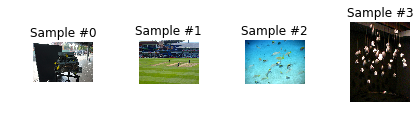

In [6]:
fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]
    print(i, sample['image'].shape, sample['rating'].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_image(**sample)
    if i == 3:
        plt.show()
        break

In [7]:
import random
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, rating = sample['image'], sample['rating']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image = transform.resize(image, (new_h, new_w))

        return {'image': image, 'rating': rating}

        
    

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, rating = sample['image'], sample['rating']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'rating': rating}

class RandomHorizontalFlip(object):
    def __init__(self, p):
        self.p = p
    
    def __call__(self, sample):
        
        image, rating = sample['image'], sample['rating']
        if random.random() < self.p:
            image = np.flip(image, 1)
            #image = io.imread(img_name+'.jpg', mode='RGB').convert('RGB')
        return {'image': image, 'rating': rating}

class Normalize(object):
    def __init__(self ):
        self.means=np.array([0.485, 0.456, 0.406]) 
        self.stds=np.array([0.229, 0.224, 0.225])
        
    def __call__(self, sample):
        image, rating = sample['image'], sample['rating']
        im=image/255
        im[:,:,0]=(image[:,:,0] - 0.485)/ 0.229 
        im[:,:,1]=(image[:,:,1]  - self.means[1])/ self.stds[1]
        im[:,:,2]=(image[:,:,2]  - self.means[2])/ self.stds[2]
        image=im
        return {'image': image, 'rating': rating}

    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, rating = sample['image'], sample['rating']
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
            
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).double(),
                'rating': torch.from_numpy(np.float64([rating])).double()}

In [8]:
output_size=(224,224)
transformed_dataset_train = ImageRatingsDataset(csv_file='train_means_normalized.csv',root_dir='Images/',
                                           transform=transforms.Compose([Rescale(output_size=(256,256)),
                                                                         RandomHorizontalFlip(0.5),
                                                                         RandomCrop(output_size=output_size),
                                                                         Normalize(),
                                                                        ToTensor(),
                                           ]))
transformed_dataset_valid = ImageRatingsDataset(csv_file='test_means_normalized.csv',root_dir='Images/',
                                           transform=transforms.Compose([Rescale(output_size=(224,224)),
                                                                         Normalize(),
                                                                        ToTensor(),
                                           ]))

In [9]:
#Simple method to avoid the loading of corrupted files
from torch.utils.data.dataloader import default_collate
bsize=64
def my_collate(batch):
    batch = list(filter (lambda x:x is not None, batch))
    return default_collate(batch)

dataloader_train = DataLoader(transformed_dataset_train, batch_size=bsize,
                        shuffle=True, num_workers=0,collate_fn=my_collate)
dataloader_valid = DataLoader(transformed_dataset_valid, batch_size=int(bsize/2),
                        shuffle=True, num_workers=0,collate_fn=my_collate)


In [10]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import copy
from torch import nn
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from random import randint

## Load a pretrained resnet18, add the custom bottleneck layers, train the whole network

In [11]:
from torchvision import models
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(num_ftrs,1))

In [12]:
class BaselineModel(nn.Module):
    def __init__(self, num_classes, keep_probability, inputsize):
    
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(inputsize, 256)
        self.drop_prob = (1 - keep_probability)
        self.relu1= nn.PReLU()
        self.drop1 = nn.Dropout(self.drop_prob)
        self.bn1=nn.BatchNorm1d(256)
        self.fc2=nn.Linear(256,256)
        self.relu2=nn.PReLU()
        self.drop2 = nn.Dropout(p=self.drop_prob)
        self.bn2=nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Weight initialization reference: https://arxiv.org/abs/1502.01852
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        """
        Feed-forward pass.
        :param x: Input tensor
        : return: Output tensor
        """
        out=self.fc1(x)
        out =self.relu1(out)
        out=self.drop1(out)
        out=self.bn1(out)
        out=self.fc2(out)
        out=self.relu2(out)
        out=self.drop2(out)
        out=self.bn2(out)
        out=self.fc3(out)
        return out

In [13]:
class convNet(nn.Module):
    #constructor
    def __init__(self,resnet,mynet):
        super(convNet, self).__init__()
        #defining layers in convnet
        self.resnet=resnet
        self.myNet=mynet
    def forward(self, x):
        x=self.resnet(x)
        x=self.myNet(x)
        return x

In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.out_features
net1 = BaselineModel(1, 0.5,num_ftrs)
net2=convNet(resnet=model_ft, mynet=net1)

In [15]:
import time
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def train_model(model, criterion, optimizer, lr_scheduler,dataloader_train,dataloader_valid,  num_epochs=100):
    since = time.time()
    train_loss_average=[]
    test_loss=[]
    best_model = model
    best_loss = 100
    use_gpu=True
    criterion.cuda()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                mode='train'
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
                dataloader=dataloader_train
            else:
                model.eval()
                mode='val'
                dataloader=dataloader_valid

            running_loss = 0.0
            model.cuda()

            counter=0
            # Iterate over data.
            for batch_idx, data in enumerate(dataloader):
                inputs = data['image']
                labels=data['rating']
                if use_gpu:
                    try:
                        inputs, labels = Variable(inputs.float().cuda()), Variable(labels.float().cuda())
                    except:
                        print(inputs,labels)
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                # wrap them in Variable

                # Set gradient to zero to delete history of computations in previous epoch. Track operations so that differentiation can be done automatically.
                optimizer.zero_grad()
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                #print('loss done')                
                # Just so that you can keep track that something's happening and don't feel like the program isn't running.
                if counter%200==0:
                    print("Reached iteration ",counter)
                counter+=1

                # backward + optimize only if in training phase
                if phase == 'train':
                    #print('loss backward')
                    loss.backward()
                    #print('done loss backward')
                    optimizer.step()
                    #print('done optim')
                # print evaluation statistics
                try:
                    running_loss += loss.data[0]
                except:
                    print('unexpected error, could not calculate loss or do a sum.')
            print('trying epoch loss')
            epoch_loss = running_loss / len(dataloader)
            print('{} Loss: {:.4f} '.format(
                phase, epoch_loss))
            if phase == 'train':
                train_loss_average.append(epoch_loss)


            # deep copy the model
            if phase == 'val':
                test_loss.append(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss=epoch_loss
                    best_model = copy.deepcopy(model)
                    print('new best loss = ',epoch_loss)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('returning and looping back')
    return best_model.cuda(), train_loss_average, test_loss

### We use 1 CUDA device to train the network. Exponential decay of the learning rate was used so that training was more stable

In [16]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
use_gpu = True
if use_gpu:
    cuda = torch.device('cuda:0')     # Default CUDA device
count=0
torch.cuda.set_device(cuda.index)

In [17]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=2):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (0.9**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [ ]:
from torchvision import models
from torch import optim
import torch.nn.functional as F

model_ft=net2


#device = cuda
criterion = nn.MSELoss()
criterion.cuda()
model_ft.cuda()
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)



# Run the functions and save the best model in the function model_ft.
model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,dataloader_train,dataloader_valid,
                       num_epochs=10)

# Save model
torch.save(model_ft, 'fine_tuned_flickerAES_normalized_dropout_resnet18_customnetworkadamnormalized1000.pt')